In [154]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.optimize as optimization
import csv
count=1


In [155]:
class SEIRD:
    """"
    'eons' (number of time points to model, default 365)
    'Susceptible' (number of susceptible individuals at time 0, default 950)
    'Exposed' (number of individuals during incubation period)
    'Infected' (number of infected individuals at time 0, default 50)
    'Resistant' (number of resistant individuals at time 0, default 0)
    'rateSE' (base rate 'beta' from S to E, default 0.05)
    'rateIR' (base rate 'gamma' from I to R, default 0.01)
    'rateEl' (base rate of isolation 'altha', from E to I, default 0.1)
    """
    def __init__(self, eons=365, Susceptible=950, Exposed = 100, Infected=50, Resistant=0, rateSE=0.05, rateIR=0.01, rateEI = 0.1):
        self.eons = eons
        self.Susceptible = Susceptible
        self.Exposed = Exposed
        self.Infected = Infected
        self.Resistant = Resistant
        self.rateSE = rateSE
        self.rateIR = rateIR
        self.rateEI = rateEI
        self.numIndividuals = Susceptible + Infected + Resistant + Exposed # total population
        self.results = None
        self.modelRun = False
        
    def run(self, death_rate):
        Susceptible = [self.Susceptible]
        Exposed = [self.Exposed]
        Infected = [self.Infected]
        Resistant = [self.Resistant]

        for step in range(1, self.eons):
            S_to_E = (self.rateSE * Susceptible[-1] * Infected[-1]) / self.numIndividuals
            E_to_I = (self.rateEI * Exposed[-1])
            I_to_R = (Infected[-1] * self.rateIR)
            
            Susceptible.append(Susceptible[-1] - S_to_E)
            Exposed.append(Exposed[-1] + S_to_E - E_to_I)
            Infected.append(Infected[-1] + E_to_I - I_to_R)
            Resistant.append(Resistant[-1] + I_to_R)
        
        # Death is death_rate* recovery group
        Death = list(map(lambda x: (x * death_rate), Resistant))
        # Heal is removed - Death
        Heal = list(map(lambda x: (x * (1-death_rate)), Resistant))
        self.results = pd.DataFrame.from_dict({'Time':list(range(len(Susceptible))),
            'Susceptible':Susceptible, 'Exposed': Exposed, 'Infected':Infected, 'Resistant':Resistant,
                                               'Death':Death, 'Heal': Heal},
            orient='index').transpose()
        self.modelRun = True
        return self.results
    
    def plot(self, title, ylabel, xlabel):
        if self.modelRun == False:
            print('Error: Model has not run. Please call SIR.run()')
            return
        print("Maximum infected case: ",
              format(int(max(self.results['Infected']))))
        fig, ax = plt.subplots(figsize=(10,6))
        plt.plot(self.results['Time'], self.results['Susceptible'], color='blue')
        plt.plot(self.results['Time'], self.results['Infected'], color='red')
        plt.plot(self.results['Time'], self.results['Exposed'], color='orange')
        plt.plot(self.results['Time'], self.results['Resistant'], color='palegreen')
        plt.plot(self.results['Time'], self.results['Heal'], color='green')
        plt.plot(self.results['Time'], self.results['Death'], color='grey')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(['Susceptible','Infected','Exposed','Removed', 'Heal', 'Death'], prop={'size': 12}, bbox_to_anchor=(0.5, 1.02), ncol=6, fancybox=True, shadow=True)
        plt.title(title, fontsize = 20)
        plt.show()

In [156]:
import numpy as np
import scipy.optimize as optimization
import pandas as pd
import pandas
#from SEIR_model import SEIR

class Estimate_parameter:
    """
    Estimate other parameters: 
            beta in SIR model and R0(basic reproduction number)
    """
    def __init__(self, nu: float, k: int, t: np.ndarray, I: np.ndarray):
        self.nu = nu
        self.k = k # the number of people a confirmed case contacts daily
        self.t = t # time step
        self.I = I  # observation
        # Estimated beta
        self.beta = self._estimate_beta()
        # self.R0
        self.R0 = self._estimate_R0()
        
    def func(self, t : np.ndarray, b):
        
        """
        K is the mean number of people a confirmed case contacts daily
        """
        #print(t)
        #print(b)
        
        #count= count+1
        #print(count)
       # b = b*10
        return np.exp((self.k*b-self.nu)*t)

    def _estimate_transmission_probablity(self):
        """
        Estimate the transmission probablity by non-linear OLS
        """
        #print('the curve fitted')
        #print(optimization.curve_fit(self.func, self.t, 
                                      #self.I, maxfev=1000)[0][0])
        return optimization.curve_fit(self.func, self.t, 
                                      self.I, maxfev=1000)[0][0]
    def _estimate_beta(self):
        """
        Estimate beta of SIR model
        """
        return self.k * self._estimate_transmission_probablity()
    
    def _estimate_R0(self):
        """
        Estimate R0(basic reproduction number)
        """
        return (self.beta)/self.nu
    
    def __str__(self): 
        """
        Representation
        """
        return f"""Estimate the transmission probablity: {round(self._estimate_transmission_probablity(), 2)} 
Estimated R0(basic reproduction number): {round(self.R0,1)}
"""



class Estimate_Outbreak(Estimate_parameter):
    
    def __init__(self, Est: Estimate_parameter, k: int, N: int,
                E0: int, I0: int, R0: int, T: int, econ: int):
        self.Est = Est 
        print(self.Est) # print R0 
        self.k = k # the number of people one case contacts daily, which nflunenced by government force
        self.N = N
        self.E0 = E0 # initial number of Enfective cases
        self.I0 = I0 # initial number of recovered cases
        self.R0 = R0
        self.S0 = N - E0 - I0 - R0# initial number of suspective cases
        self.alpha = 1/T # T is the mean of incubation period
        self.econ = econ
        self.model = None
        
        
    def run_SIER(self,title:str, ylabel:str, xlabel:str, death_rate: float, show_Sus = True) -> pandas.core.frame.DataFrame:
        """
        Run SIER model
        """
        Est_beta = self.Est._estimate_transmission_probablity()*self.k
        sier = SEIRD(eons=self.econ, Susceptible=self.N-self.E0-self.I0-self.R0, Exposed = self.E0, 
                    Infected=self.I0, Resistant=self.R0, rateSE=Est_beta, rateIR=self.Est.nu, 
                    rateEI = self.alpha)
        result = sier.run(death_rate)
        # Draw plot
        if show_Sus:
            sier.plot(title, ylabel, xlabel)
        else:
            sier.plot_noSuscep(title, ylabel, xlabel)
        
        self.model = sier
        return result

In [157]:
def openNhead(N):
    with open("world_data.csv") as myfile:
        head = [next(myfile) for x in range(N)]
    print(head)
    
openNhead(10)


['date,deaths,confirmed,recovered,CFR_1,CFR_2\n', '\n', '2020-01-21,17,555,28,0.37777777777777777,0.03063063063063063\n', '\n', '2020-01-22,35,1208,58,0.3763440860215054,0.028973509933774833\n', '\n', '2020-01-23,44,1594,66,0.4,0.027603513174404015\n', '\n', '2020-01-24,68,2379,75,0.4755244755244755,0.028583438419503993\n', '\n']


In [158]:
from datetime import datetime
dataset = pd.read_csv("world_data.csv")
#dataset['Date'] = datetime.strptime(dataset['Date'], '%Y-%m-%d')
dataset['date'] = pd.to_datetime(dataset["date"]).dt.strftime("%Y%m%d")
#dataset['date'] = pd.to_datetime(dataset['date'],infer_datetime_format=True)
#indexedDataset = dataset.set_index('date')
test=dataset.head(10)


In [159]:
""""test.date
def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day
to_integer(test['date'])"""

'"test.date\ndef to_integer(dt_time):\n    return 10000*dt_time.year + 100*dt_time.month + dt_time.day\nto_integer(test[\'date\'])'

In [160]:
test

,date,deaths,confirmed,recovered,CFR_1,CFR_2
0,20200121,17,555,28,0.377778,0.030631
1,20200122,35,1208,58,0.376344,0.028974
2,20200123,44,1594,66,0.400000,0.027604
3,20200124,68,2379,75,0.475524,0.028583
4,20200125,98,3556,91,0.518519,0.027559
5,20200126,138,5044,113,0.549801,0.027359
6,20200127,213,8504,168,0.559055,0.025047
7,20200128,264,11743,233,0.531187,0.022481
8,20200129,304,14400,269,0.530541,0.021111
9,20200130,384,18160,365,0.512684,0.021145


Estimate the transmission probablity: 1.18 
Estimated R0(basic reproduction number): 16.5



Baseline before april
Estimate the transmission probablity: 1.18 
Estimated R0(basic reproduction number): 16.5

Maximum infected case:  3658311034


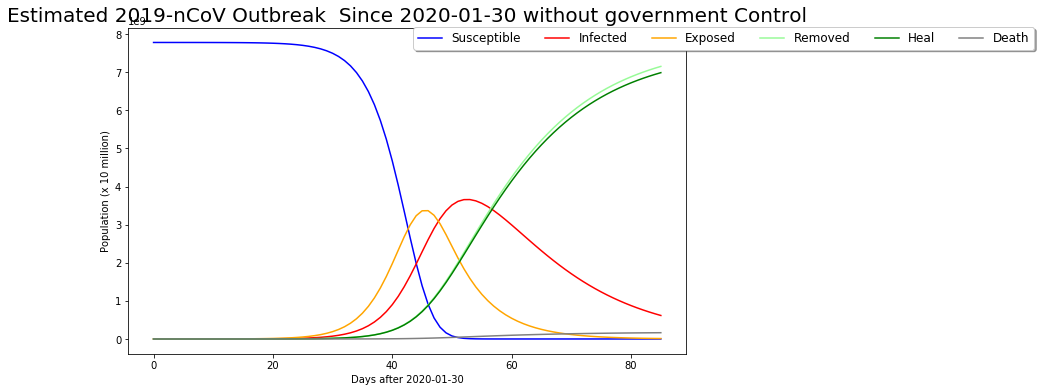

In [165]:
#t = np.asarray(test.date)
t = np.asarray([0,1,2,3,4,5,6,7,8,9])
I = np.asarray(test.confirmed)

def main():
    Est = Estimate_parameter(nu = 1/14, k =1 , t = t, I = I)
    print(Est)
    
    print("\n\nBaseline before april")
    baseline = Estimate_Outbreak(Est, k = 1, N=7780393450,
                E0 = 90800, I0 = 18160, R0 = 365, T=7, econ = 86)
    result = baseline.run_SIER('Estimated 2019-nCoV Outbreak  Since 2020-01-30 without government Control',
        'Population (x 10 million)', 'Days after 2020-01-30', death_rate = 0.023)
    
    
if __name__ == '__main__':
    main()
   


